# Contradictory, My Dear Watson

# Introduction

The task is to create an NLI model that assigns labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses.

We will use traditional NLP approaches (TF-IDF vectorization, word embeddings, Bag-Of-Words), sentiment analysis and roBERTa using TPUs for the completion of the task.

# Importing libraries

In [1]:
import os
os.system("pip3 install googletrans==3.1.0a0 > /dev/null 2>&1")
os.system("pip3 install seaborn > /dev/null 2>&1")
os.system("pip3 install transformers > /dev/null 2>&1")
os.system("pip3 install TextBlob > /dev/null 2>&1")
os.system("pip3 install spacy > /dev/null 2>&1")
os.system("pip3 install nltk > /dev/null 2>&1")
os.system("pip3 install scikit-learn > /dev/null 2>&1")
os.system("pip3 install lazypredict > /dev/null 2>&1")
os.system("pip3 install tensorflow > /dev/null 2>&1")
os.system("pip3 install sentencepiece> /dev/null 2>&1")
os.system("pip3 install datasets > /dev/null 2>&1")

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
#basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLP specific libraries

from transformers import BertTokenizer, TFBertModel
from googletrans import Translator, LANGUAGES
from textblob import TextBlob
import spacy
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from transformers import BertTokenizer, TFBertModel
import re 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import cosine_similarity


# Various
import timeit
from lazypredict.Supervised import LazyClassifier
from datasets import load_dataset

# Tensorflow 
import tensorflow as tf
from tensorflow.keras.wrappers.scikit_learn  import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow_probability as tfp

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# TPU distribution strategy

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# EDA

**Loading data**
<a id="Loading"></a>

In [4]:
train = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')
test = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/test.csv')
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
train.head(10)

Train set shape: (12120, 6)
Test set shape: (5195, 5)


,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
5,ed7d6a1e62,"Bir çiftlikte birisinin, ağıla kapatılmış bu ö...",Çiftlikte insanlar farklı terimler kullanırlar.,tr,Turkish,0
6,5a0f4908a0,ریاست ہائے متحدہ امریکہ واپس آنے پر، ہج ایف بی...,ہیگ کی تفتیش ایف بی آئی اہلکاروں کی طرف سے کی...,ur,Urdu,0
7,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,English,2
8,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,English,1
9,8c10229663,Через каждые сто градусов пятна краски меняют ...,Краска изменяется в соответствии с цветом.,ru,Russian,0


In [5]:
print(train['premise'][3], '\n', train['hypothesis'][3])

you know they can't really defend themselves like somebody grown uh say my age you know yeah 
 They can't defend themselves because of their age.


**Descriptions of features**

<a id="features"></a>

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12120 entries, 0 to 12119
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          12120 non-null  object
 1   premise     12120 non-null  object
 2   hypothesis  12120 non-null  object
 3   lang_abv    12120 non-null  object
 4   language    12120 non-null  object
 5   label       12120 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 568.2+ KB


**Distribution of the target variable**
<a id="Distribution"></a>

In [7]:
label_distribution = train["label"].value_counts(normalize = True)
print(label_distribution)

0   0.34
2   0.34
1   0.32
Name: label, dtype: float64


**Missing data overview**
<a id="Missing"></a>

In [8]:
print("amount of missing values in train dataset:")
print(train.isna().sum())
print("amount of missing values in test dataset:")
print(test.isna().sum())

amount of missing values in train dataset:
id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64
amount of missing values in test dataset:
id            0
premise       0
hypothesis    0
lang_abv      0
language      0
dtype: int64


**Distribution of categorical variables**
<a id="categorical"></a>

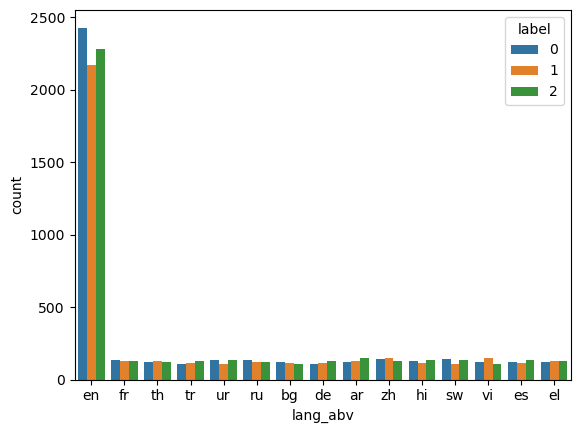

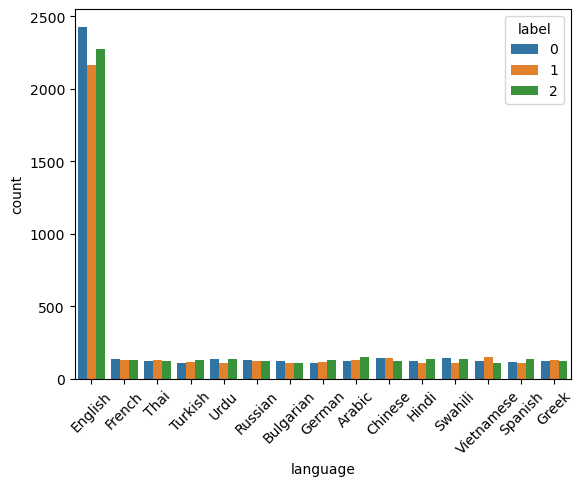

In [9]:
# Plot distribution of languages for labels and comparison of two variables to check for difference between 2 features representing language
sns.countplot(data=train, x='lang_abv',  hue='label')
plt.show()
sns.countplot(data=train, x='language',  hue='label')
plt.xticks(rotation=45)
plt.show()

The variables may be considered identical.

In [10]:
language_distribution = train["language"].value_counts(normalize = True)
print(language_distribution)

English      0.57
Chinese      0.03
Arabic       0.03
French       0.03
Swahili      0.03
Urdu         0.03
Vietnamese   0.03
Russian      0.03
Hindi        0.03
Greek        0.03
Thai         0.03
Spanish      0.03
Turkish      0.03
German       0.03
Bulgarian    0.03
Name: language, dtype: float64


# Translation of multilingual texts into english for standartization of modeling approach

In [11]:
train['language'] = train['language'].str.lower()
train['language'].head()
test['language'] = test['language'].str.lower()

In [12]:

# Get the language codes and names as a list of tuples
languages_list = [(code, name) for code, name in LANGUAGES.items()]

# Calculate the number of languages per column, rounded up
num_languages = len(languages_list)
num_columns = 4
languages_per_column = -(-num_languages // num_columns)

# Print the languages in 4 columns
for i in range(languages_per_column):
    for j in range(num_columns):
        index = i + j * languages_per_column
        if index < num_languages:
            code, name = languages_list[index]
            print(f"{code:<5} {name:<20}", end="")
    print()

af    afrikaans           fy    frisian             lo    lao                 st    sesotho             
sq    albanian            gl    galician            la    latin               sn    shona               
am    amharic             ka    georgian            lv    latvian             sd    sindhi              
ar    arabic              de    german              lt    lithuanian          si    sinhala             
hy    armenian            el    greek               lb    luxembourgish       sk    slovak              
az    azerbaijani         gu    gujarati            mk    macedonian          sl    slovenian           
eu    basque              ht    haitian creole      mg    malagasy            so    somali              
be    belarusian          ha    hausa               ms    malay               es    spanish             
bn    bengali             haw   hawaiian            ml    malayalam           su    sundanese           
bs    bosnian             iw    hebrew              mt 

In [13]:
train.loc[train['lang_abv'] == 'zh', 'lang_abv'] = 'zh-cn'
test.loc[test['lang_abv'] == 'zh', 'lang_abv'] = 'zh-cn'

In [14]:
def translate_text(text, lang, dest='en'):
    if lang != 'en':
        translator = Translator()
        text = translator.translate(text, src=lang, dest='en').text
    return text
print(translate_text("der Translator funktioniert wie gewünscht.", lang = 'de'))

the translator works as expected.


In [15]:
start_time = timeit.default_timer()  # start the timer
train_english_subset = train[:100].apply(lambda x: (translate_text(x['premise'], str(x['lang_abv']), 'en'), translate_text(x['hypothesis'], str(x['lang_abv']), 'en')), axis=1)
train_english_subset['premise_english'] = train_english_subset.apply(lambda x: x[0])
train_english_subset['hypothesis_english'] = train_english_subset.apply(lambda x: x[1])
end_time = timeit.default_timer()
elapsed_time = end_time - start_time  # calculate elapsed time
print(f"Total time taken: {elapsed_time:.2f} seconds")


start_time1 = timeit.default_timer()  # start the timer
premise_texts = train[:100]['premise']
hypothesis_texts = train[:100]['hypothesis']
langs = train[:100]['lang_abv']

translated_premise = [translate_text(premise, lang) for premise, lang in zip(premise_texts, langs)]
translated_hypothesis = [translate_text(hypothesis, lang) for hypothesis, lang in zip(hypothesis_texts, langs)]
end_time1 = timeit.default_timer()  # end the timer
elapsed_time1 = end_time1 - start_time1  # calculate elapsed time
print(f"Total time taken: {elapsed_time1:.2f} seconds")

Total time taken: 8.34 seconds
Total time taken: 6.17 seconds


In [16]:
train = train[train['lang_abv'] == 'en']

In [17]:
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,english,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,english,2
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,english,0
7,fdcd1bd867,From Cockpit Country to St. Ann's Bay,From St. Ann's Bay to Cockpit Country.,en,english,2
8,7cfb3d272c,"Look, it's your skin, but you're going to be i...",The boss will fire you if he sees you slacking...,en,english,1


# Sentiment analysis using TextBlob

In [18]:
# Perform sentiment analysis using TextBlob
sentiment_scores_premise = []
for text in train['premise']:
    blob = TextBlob(text)
    sentiment_scores_premise.append(blob.sentiment.polarity)
print(sentiment_scores_premise[:8])

sentiment_scores_hypothesis = []
for text in train['hypothesis']:
    blob1 = TextBlob(text)
    sentiment_scores_hypothesis.append(blob1.sentiment.polarity)
print(sentiment_scores_hypothesis[:8])

[0.0, 0.0, 0.2, 0.0, -0.05, 0.21666666666666667, 0.20625, 0.4]
[0.1, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0]


We will extract the difference in sentiments between premise and hypothesis

In [19]:
diff_in_sentiments = np.array(sentiment_scores_premise) - np.array(sentiment_scores_hypothesis)
diff_in_sentiments_labels = pd.DataFrame({'label': np.array(train['label']),
                                          'diff_in_sentiments': diff_in_sentiments,
                                          'language': np.array(train['language']),
                                           'sentiment_scores_premise': np.array(sentiment_scores_premise),
                                           'sentiment_scores_hypothesis': np.array(sentiment_scores_hypothesis)})
diff_in_sentiments_labels.head(3)

,label,diff_in_sentiments,language,sentiment_scores_premise,sentiment_scores_hypothesis
0,0,-0.10,english,0.00,0.10
1,2,0.00,english,0.00,0.00
2,0,0.20,english,0.20,0.00


In [20]:
mean_sentiments_diff = diff_in_sentiments_labels[diff_in_sentiments_labels['language'] == 'english'].groupby('label').\
mean(["diff_in_sentiments", 'sentiment_scores_hypothesis', 'sentiment_scores_premise'])
mean_sentiments_diff

,diff_in_sentiments,sentiment_scores_premise,sentiment_scores_hypothesis
label,,,
0,0.02,0.09,0.07
1,0.01,0.09,0.08
2,0.05,0.08,0.03


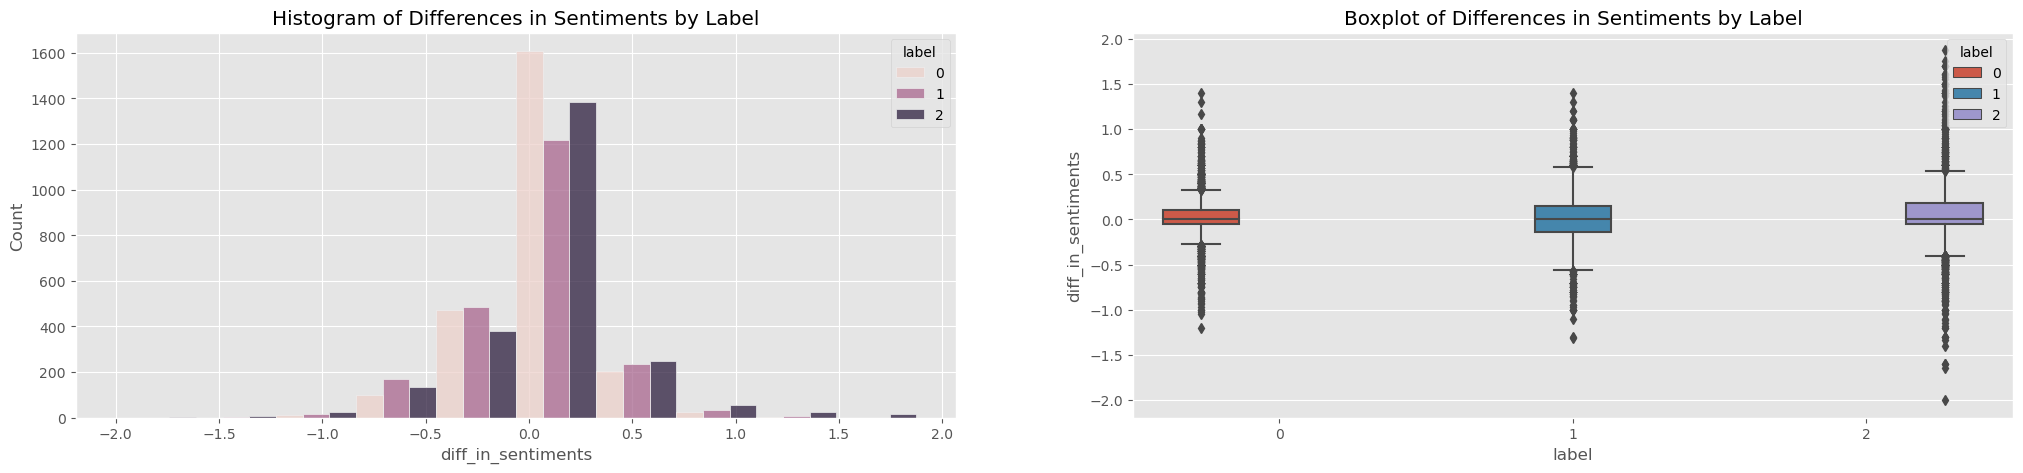

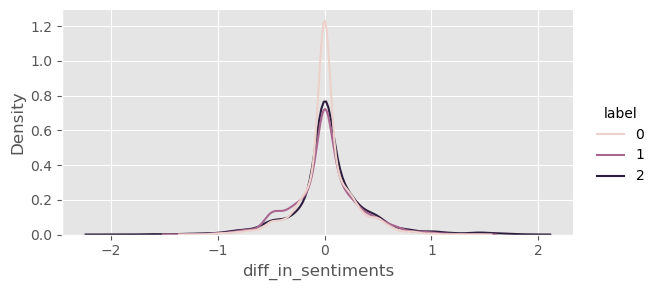

In [21]:
plt.style.use('ggplot')

fig, axs = plt.subplots(ncols=2, figsize=(25, 5))

sns.histplot(data=diff_in_sentiments_labels, 
             x='diff_in_sentiments', 
             bins=10,  hue='label',  multiple = 'dodge', ax=axs[0])
axs[0].set(title='Histogram of Differences in Sentiments by Label')

sns.boxplot(data=diff_in_sentiments_labels, 
            y='diff_in_sentiments', 
            x='label', hue = 'label', ax=axs[1])
axs[1].set(title='Boxplot of Differences in Sentiments by Label')

sns.displot(data=diff_in_sentiments_labels, 
            x='diff_in_sentiments', hue = 'label',  kind="kde",
            height=3, aspect=2)


plt.show()

The conclusions we might draw:
*     the difference is very sparse, there are a lot of outliers by all labels.
*     the absolute difference above 1 occurs more often by label 2.
*     the text is more likely to belong to label 0 in case the difference in polarity is near zero.
*     density plot shows a slight peak for label 1 around the values -0.6 to -0.3 for the difference in polarity.
*     the polarity sentiment analysis is applicable only to the english texts, i.e. to 57% of our dataset.
*     we might consider creating categorical variable for sentiments, that will split the data as follows:
        1. difference from -0.2 to 0.2 
        2. difference from -0.6 to -0.3
        3. difference lower than -1.0 and higher than 1.0.
        4. texts on other languages together with the texts that do not belong to any of the above mentioned groups.

In [22]:
train['diff_in_sentiments'] = diff_in_sentiments
train['sentiment_group'] = np.nan
train.loc[(train['diff_in_sentiments'] >= -0.2) & 
                              (train['diff_in_sentiments'] <= 0.2), 'sentiment_group'] = 'GROUP1'
train.loc[(train['diff_in_sentiments'] >= -0.6) & 
                              (train['diff_in_sentiments'] <= -0.3), 'sentiment_group'] = 'GROUP2'
train.loc[(train['diff_in_sentiments'] >= 1.0) | 
                              (train['diff_in_sentiments'] <= -1.0), 'sentiment_group'] = 'GROUP3'
train.loc[train['sentiment_group'].isna(), 'sentiment_group'] = 'GROUP4'

print(train['sentiment_group'].value_counts())

GROUP1    4444
GROUP4    1685
GROUP2     627
GROUP3     114
Name: sentiment_group, dtype: int64


# Number of words

In [23]:
text_len_premise=train['premise'].str.split().map(lambda x: len(x))
text_len_hypothesis=train['hypothesis'].str.split().map(lambda x: len(x))
train['diff_in_length'] = text_len_premise - text_len_hypothesis

train.head(2)

,id,premise,hypothesis,lang_abv,language,label,diff_in_sentiments,sentiment_group,diff_in_length
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,english,0,-0.10,GROUP1,-4
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,english,2,0.00,GROUP1,5


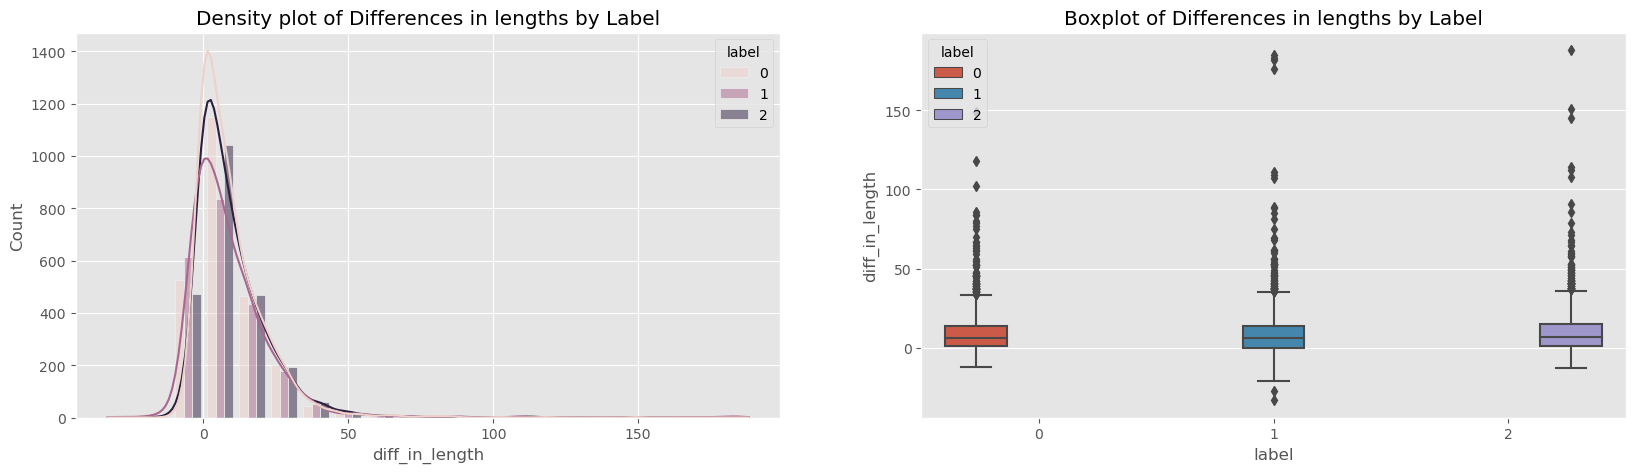

In [24]:
plt.style.use('ggplot')
fig, axs = plt.subplots(ncols=2, figsize=(20, 5))

sns.histplot(
    data=train, 
    x="diff_in_length", hue="label", multiple = 'dodge',
    bins = 20, ax=axs[0], shrink=.8, kde =True)
axs[0].set(title='Density plot of Differences in lengths by Label')

sns.boxplot(
    data=train, 
    y='diff_in_length', 
    x='label', hue = 'label', ax=axs[1])
axs[1].set(title='Boxplot of Differences in lengths by Label')

plt.show()

We cannot draw many conclusions from the received distribution, but the difference below -5 indicates label 1, whereas the difference between 0 and 20 indicates that the likelyhood of label 1 is slighly lower than that of the other categories.

In [25]:
train['length_group'] = np.nan
train.loc[train['diff_in_length'] <= -5 , 'length_group'] = 'LENGTH_GROUP1'
train.loc[(train['diff_in_length'] >= 0) & 
                              (train['diff_in_length'] <= 20), 'length_group'] = 'LENGTH_GROUP2'
train.loc[train['length_group'].isna(), 'length_group'] = 'LENGTH_GROUP3'
print(train['length_group'].value_counts())

LENGTH_GROUP2    4682
LENGTH_GROUP3    1947
LENGTH_GROUP1     241
Name: length_group, dtype: int64


# Average word length

In [26]:
word_len_premise=train['premise'].str.split().apply(lambda x : [len(i) for i in x])
word_len_hypothesis=train['hypothesis'].str.split().apply(lambda x : [len(i) for i in x])
from statistics import mean
word_len_premise_means = [mean(word_len) for word_len in word_len_premise]
word_len_hypothesis_means = [mean(word_len) for word_len in word_len_hypothesis]
train['word_len_diff_means'] = np.array(word_len_premise_means) - np.array(word_len_hypothesis_means)
print(train['word_len_diff_means'])

0        1.04
1       -0.50
3       -0.90
7       -0.14
8        0.21
         ... 
12115    1.39
12116    0.54
12117    0.29
12118    0.00
12119   -0.25
Name: word_len_diff_means, Length: 6870, dtype: float64


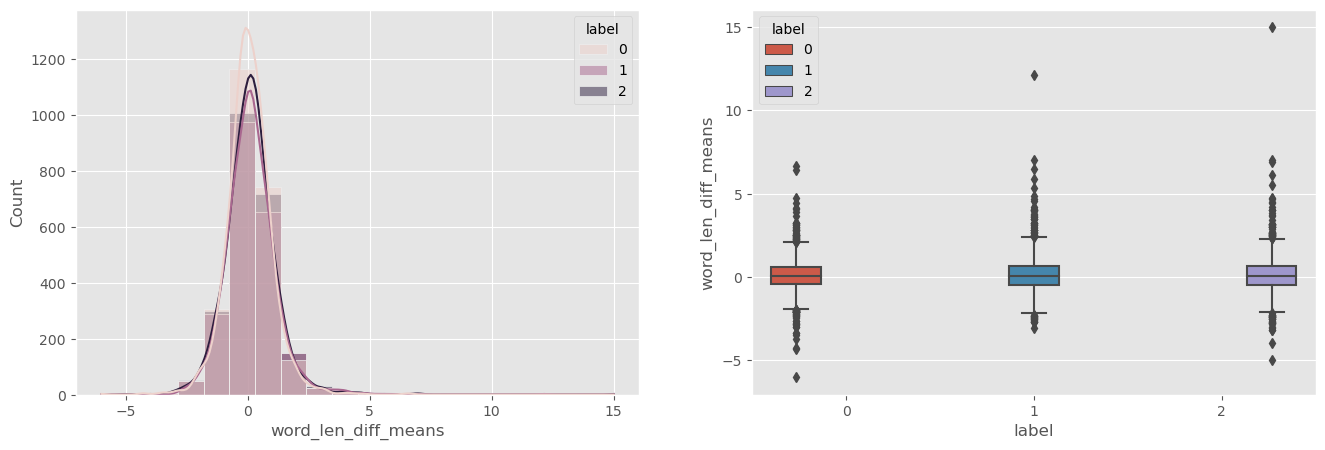

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(16,5))

sns.histplot(
    data=train, 
    x="word_len_diff_means", hue="label", 
     ax=axs[0], kde = True, bins = 20)

sns.boxplot(
    data=train, 
    y='word_len_diff_means', 
    x='label', hue='label', ax=axs[1])

plt.show()

The distribution of differences in mean word lengthes seems nearly identical for target categories. We will not include this variable in our model.

# Generating word embeddings via SpaCy

In [28]:

# Load the language model
!python -m spacy download en_core_web_sm --quiet
nlp = spacy.load("en_core_web_sm") 

# Tokenize the sentence
spacy_premises_train =[nlp(sentence) for sentence in train["premise"]] 
spacy_hypothesis_train =[nlp(sentence) for sentence in train["hypothesis"]]

word_embeddings_train_premises = []
for token in spacy_premises_train:
    word_embeddings_train_premises.append(token.vector) 
    
word_embeddings_train_hypothesis = []
for token in spacy_hypothesis_train:
    word_embeddings_train_hypothesis.append(token.vector) 
    

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Count Vectorizer + TF-IDF Vectorizer

In [29]:
def preprocess_text(text, lang='english'):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Lowercase the tokens
    tokens = [token.lower() for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Stem the tokens
    stemmer = SnowballStemmer('english')
    tokens = [stemmer.stem(token) for token in tokens]

    return ' '.join(tokens)


def get_tokenized_data(data, lang_col, text_col):
    return [preprocess_text(row[text_col], row[lang_col]) for _, row in data.iterrows()]


train_tokenized_premises = get_tokenized_data(train, 'lang_abv', 'premise')
train_tokenized_hypothesis = get_tokenized_data(train, 'lang_abv', 'hypothesis')


# Create bag-of-words using CountVectorizer
count_vectorizer = CountVectorizer()
bow_train_premises = count_vectorizer.fit_transform(train_tokenized_premises)
bow_train_hypothesis = count_vectorizer.transform(train_tokenized_hypothesis)

# Create tf-idf vectors using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_train_premises = tfidf_vectorizer.fit_transform(train_tokenized_premises)
tfidf_train_hypothesis = tfidf_vectorizer.transform(train_tokenized_hypothesis)

# Cosine Similarity calculation

We generate cosine similarity between vectors and word embeddings for premises and hypothesis

In [30]:
tfidf_similarities_train = np.diag(cosine_similarity(tfidf_train_premises, tfidf_train_hypothesis))
bow_similarities_train = np.diag(cosine_similarity(bow_train_premises, bow_train_hypothesis))
embeddings_similarities_train = np.diag(cosine_similarity(word_embeddings_train_premises, word_embeddings_train_hypothesis))

# Combining features

In [31]:
encoder = OneHotEncoder(handle_unknown='ignore')
train_groups_encoded = pd.DataFrame(encoder.fit_transform(train[['sentiment_group', 'length_group']]).toarray())


In [32]:
train_groups_encoded.head()

,0,1,2,3,4,5,6
0,1.00,0.00,0.00,0.00,0.00,0.00,1.00
1,1.00,0.00,0.00,0.00,0.00,1.00,0.00
2,1.00,0.00,0.00,0.00,0.00,1.00,0.00
3,1.00,0.00,0.00,0.00,0.00,1.00,0.00
4,1.00,0.00,0.00,0.00,0.00,1.00,0.00


In [33]:
print(tfidf_similarities_train.shape,
     bow_similarities_train.shape,
     embeddings_similarities_train.shape,
     train_groups_encoded.shape)
train_english_only = np.concatenate((tfidf_similarities_train.reshape(-1,1), 
                                        bow_similarities_train.reshape(-1,1), 
                                        embeddings_similarities_train.reshape(-1,1), 
                                        train_groups_encoded), axis=1)
print(train_english_only.shape)
train_english_only = pd.DataFrame(train_english_only)

(6870,) (6870,) (6870,) (6870, 7)
(6870, 10)


# Prediction from LazyClassifier

In [34]:
y = train['label']
X_train, X_val_complete, y_train, y_val = train_test_split(train_english_only, y, test_size=0.2, random_state=42)
clf = LazyClassifier(predictions=True, verbose=0, random_state=42)
models, predictions = clf.fit(X_train, X_val_complete, y_train, y_val)
models.head(10)

100%|██████████| 29/29 [00:19<00:00,  1.45it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
AdaBoostClassifier,0.45,0.45,None,0.44,0.31
SVC,0.44,0.45,None,0.43,2.53
BernoulliNB,0.44,0.44,None,0.43,0.02
LogisticRegression,0.44,0.44,None,0.43,0.06
RidgeClassifier,0.44,0.44,None,0.42,0.03
LinearSVC,0.44,0.44,None,0.42,1.30
RidgeClassifierCV,0.44,0.44,None,0.42,0.05
LGBMClassifier,0.44,0.44,None,0.43,0.41
CalibratedClassifierCV,0.44,0.44,None,0.42,4.36


Traditional NLP approaches (TF-IDF vectorization, word embeddings, Bag-Of-Words)  have not brought much for the NLI task of differentiation between relation of 2 sentences. Sentiment analysis has been also less predictive then expected. 

# Natural Language Inference with roBERTa

The approach from BertExperiment II https://www.kaggle.com/code/nicknosorogov/bertexperiment-ii has been used as a basis. The main difference - training of the model on only English training samples. Prior to applying model to the test set we will translate it into english.

In [35]:
train = pd.read_csv('/kaggle/input/contradictory-my-dear-watson/train.csv')
train = train[['premise', 'hypothesis', 'lang_abv', 'label']]
train = train[train['lang_abv'] == 'en']

In [36]:
def load_mnli(use_validation=True):
    result=[]
    dataset=load_dataset('multi_nli')
    print(dataset)
    for record in dataset['train']:
        c1, c2, c3 = record['premise'],record['hypothesis'], record['label']
        if c1 and c2 and c3 in {0, 1, 2}:
            result.append((c1, c2, c3, 'en'))
    result=pd.DataFrame(result, columns=['premise', 'hypothesis', 'label', 'lang_abv'])
    return result

mnli=load_mnli()
mnli

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['promptID', 'pairID', 'premise', 'premise_binary_parse', 'premise_parse', 'hypothesis', 'hypothesis_binary_parse', 'hypothesis_parse', 'genre', 'label'],
        num_rows: 9832
    })
})


,premise,hypothesis,label,lang_abv
0,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,1,en
1,you know during the season and i guess at at y...,You lose the things to the following level if ...,0,en
2,One of our number will carry out your instruct...,A member of my team will execute your orders w...,0,en
3,How do you know? All this is their information...,This information belongs to them.,0,en
4,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,1,en
...,...,...,...,...
392697,"Clearly, California can - and must - do better.",California cannot do any better.,2,en
392698,It was once regarded as the most beautiful str...,So many of the original buildings had been rep...,1,en
392699,Houseboats are a beautifully preserved traditi...,The tradition of houseboats originated while t...,0,en
392700,Obituaries fondly recalled his on-air debates ...,The obituaries were beautiful and written in k...,1,en


In [37]:
from transformers import BertTokenizer, TFBertModel, AutoTokenizer,TFAutoModel
model_roBerta ='joeddav/xlm-roberta-large-xnli'
#model_Bert = 'bert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_roBerta)
model = TFAutoModel.from_pretrained(model_roBerta)

Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


In [38]:

train=pd.concat([train, mnli.loc[:20000]], axis=0)
SEQ_LEN = 236  

def bert_encode(df, tokenizer):    
    batch_premises = df['premise'].tolist()
    batch_hypothesis = df['hypothesis'].tolist()

    tokens = tokenizer(batch_premises, batch_hypothesis, max_length = SEQ_LEN,
                   truncation=True, padding='max_length',
                   add_special_tokens=True, return_attention_mask=True,
                   return_tensors='tf')
    inputs = {
          'input_ids': tokens['input_ids'], 
          'attention_mask': tokens['attention_mask'],
            }
    return inputs
train_input = bert_encode(train, tokenizer)

In [39]:
from tensorflow.keras import regularizers

def build_model():   # hp
    #FBertModel
    encoder = TFAutoModel.from_pretrained(model_roBerta)
    input_ids = tf.keras.Input(shape=(SEQ_LEN,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.Input(shape=(SEQ_LEN,), dtype=tf.int32, name="attention_mask")
        
    embedding = encoder([input_ids, attention_mask])[0] 
    inputs=[input_ids, attention_mask] 
    hp_units1 = 64 
    hp_units2 = 32 
    x = tf.keras.layers.Dense(units = hp_units1, activation=tf.nn.relu)(embedding[:,0,:])
    x = tf.keras.layers.Dense(units = hp_units2, activation=tf.nn.relu, kernel_regularizer=regularizers.l2(l2=1e-4))(x)
    output = tf.keras.layers.Dense(3, activation='softmax')(x)    #  (embedding[:,0,:])
      
    model = tf.keras.Model(inputs=inputs, outputs=output)
    hp_learning_rate = 1e-6 
    model.compile(tf.keras.optimizers.Adam(learning_rate = hp_learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])   
    return model 


In [40]:
with strategy.scope(): # defines the compute distribution policy for building the model. or in other words: makes sure that the model is created on the TPU/GPU/CPU, depending on to what the Accelerator is set in the Notebook Settings
    model = build_model() # our model is being built
    model.summary()       # let's look at some of its properties

Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 236)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 236)]        0           []                               
                                                                                                  
 tfxlm_roberta_model_1 (TFXLMRo  TFBaseModelOutputWi  559890432  ['input_ids[0][0]',              
 bertaModel)                    thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 236,                                           

In [41]:
for key in train_input.keys():
    train_input[key] = train_input[key][:,:SEQ_LEN]

In [42]:
history = model.fit(train_input, train['label'], epochs = 10, batch_size=64, 
                    validation_split = 0.2) #,callbacks=[hist]) verbose = 1,   

Epoch 1/10
336/336 [==============================] - 369s 617ms/step - loss: 0.3577 - accuracy: 0.8864 - val_loss: 0.1850 - val_accuracy: 0.9438
Epoch 2/10
336/336 [==============================] - 101s 301ms/step - loss: 0.2426 - accuracy: 0.9209 - val_loss: 0.1696 - val_accuracy: 0.9464
Epoch 3/10
336/336 [==============================] - 101s 301ms/step - loss: 0.2198 - accuracy: 0.9272 - val_loss: 0.1638 - val_accuracy: 0.9457
Epoch 4/10
336/336 [==============================] - 101s 301ms/step - loss: 0.2011 - accuracy: 0.9344 - val_loss: 0.1683 - val_accuracy: 0.9459
Epoch 5/10
336/336 [==============================] - 101s 301ms/step - loss: 0.1872 - accuracy: 0.9389 - val_loss: 0.1651 - val_accuracy: 0.9473
Epoch 6/10
336/336 [==============================] - 101s 300ms/step - loss: 0.1662 - accuracy: 0.9463 - val_loss: 0.1710 - val_accuracy: 0.9485
Epoch 7/10
336/336 [==============================] - 101s 301ms/step - loss: 0.1585 - accuracy: 0.9499 - val_loss: 0.1679 -

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


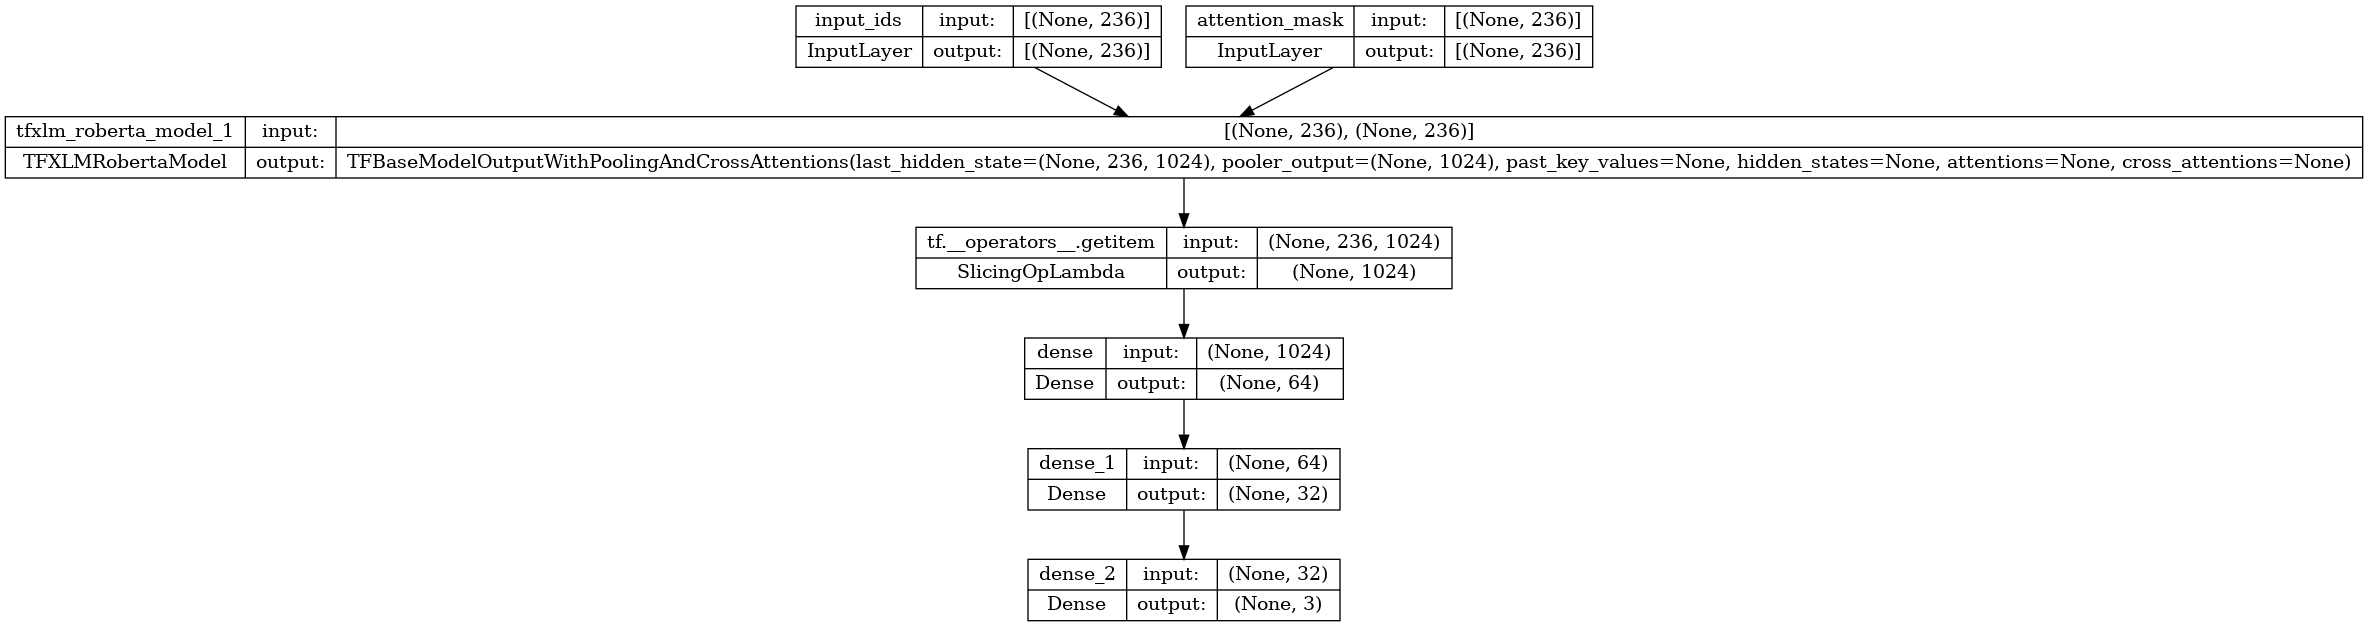

In [43]:
tf.keras.utils.plot_model(model, show_shapes=True)

# Google Translator

Since the model has learned only on English texts we will translate the test samples prior to predicting.

In [44]:
def translate(text):
    # Since not all of the languages from the dataset are represented in nltk modules we will remove
    # the stopwords and do stemming only for appicable languages only after translation.
    try:
       # if lang not in ['english', 'french', 'russian', 'german', 'arabic', 'spanish']: 
        translator = Translator()
        return translator.translate(text, dest='en').text
    except:
        return text

In [45]:
test_translated = test.apply(lambda x: (translate_text(x['premise'], str(x['lang_abv']), 'en'), 
                                        translate_text(x['hypothesis'], str(x['lang_abv']), 'en')), axis=1) ## applying translation to the test set.
test['premise'] = test_translated.apply(lambda x: x[0])
test['hypothesis'] = test_translated.apply(lambda x: x[1])
test['lang_abv'] = 'en'


In [46]:
test_input = bert_encode(test, tokenizer)
 #same for the test set we need to put it in the same size of the model
for key in test_input.keys():
    test_input[key] = test_input[key][:,:SEQ_LEN]
predictions = [np.argmax(i) for i in model.predict(test_input)]

163/163 [==============================] - 35s 169ms/step


# Submission

In [47]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions
submission.to_csv("submission.csv", index = False)

# Final thoughts

Traditional NLP approaches (TF-IDF vectorization, word embeddings, Bag-Of-Words)  have not brought much for the NLI task of differentiation between relation of 2 sentences. Sentiment analysis has been also less predictive than expected. 

The best prediction could be achieved with the help of multi_nli and RoBERTa. Applying it to only English samples did not approve the performance significantly. However applying prior translation might be a good step in the standartization pipelene for other NLP tasks.